<a href="https://colab.research.google.com/github/vincebarokie/crypto_model/blob/main/crypto_price_machine_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Crypto Price Machine Learning Model

Submitted By: Raymund Vincent Ricabar

**Dataset** is found [here](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset)

This dataset was extracted using web scraping and various python packages like investpy, yahoo finance, pandas data reader.

**TODOS**

- [x] EDA on trending & potential of the Celo (can by any cryptocurrency)
- [ ] Predict prices (close) of Celo (can be any cryptocurrency) 
- [ ] Plot true value and predicted value over time

|No |	Columns	| Descriptions |
|:--|---------|--------------:|
|1	|Date	|Date of the crypto prices|
|2	|Close	|Closing prices of crypto(dollars)|
|3	|Open	|Opening price of crypto on the respective date(Dollars)|
|4	|High	|Highest price of crypto on the respective date(Dollars)|
|5	|Low	|Lowest price of crypto on the respective date(Dollars)|
|6	|Vol.	|Volume of crypto on the respective date(Dollars)|

## Data Cleaning

We will be setting our imports, loading our dataset and perform some initial data exploration in this section.

In [14]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [127]:
# imports
import pandas as pd
import numpy as np
# config pandas 
pd.options.display.float_format = '{:.5f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**My Custom Functions**

In [123]:
# model performance evulation function
def evaluate_model(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  # print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')
  return {"r2": r2, "mae": mae, "mse": mse, "rmse": rmse}

def actual_preds_plot(X_test, xaxis, actual, preds):
  # line plot of crypto price over time
  fig, ax = plt.subplots(figsize = (10, 5))
  ax = sns.lineplot(x = X_test[xaxis], y = X_test[actual])
  ax = sns.lineplot(x = X_test[xaxis], y = X_test[preds])
  ax.set(title = 'Celo Price($) Over Time', ylabel = 'Price ($)')
  plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
  plt.legend(labels = ['actual', 'predictions'], loc = 'best')
  plt.show()

def build_n_eval_model(preproc, model, X_train, X_test, y_train, y_test):
  # build the pipeline and train the model
  model_pipe = make_pipeline(preproc, model)
  model_pipe.fit(X_train, y_train)
  # get test predictions
  preds = model_pipe.predict(X_test)
  # evaluate the model
  print('Testing Data Metrics')
  for k, v in evaluate_model(y_test, preds).items():
    print(f'{k}_score: {v}')
  
  # combine preds and true values to your features
  X_test['predictions'] = preds
  X_test['actual'] = y_test
  # bring back the date feature
  X_test['date'] = pd.to_datetime(X_test[['month','day','year']])
  print('\n')
  # visualize the actual and predictions
  actual_preds_plot(X_test, 'Date', 'actual', 'predictions')

In [85]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/CodingDojo_DS/dataset_files/Celo.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2020-05-22,0.82595,0.97836,0.79553,0.83266,2019357,USD
1,2020-05-23,0.83277,2.51691,0.83277,2.49621,3645282,USD
2,2020-05-24,2.43167,3.91659,1.47054,1.81345,3305900,USD
3,2020-05-25,1.80970,1.93593,1.42681,1.43638,2211306,USD
4,2020-05-26,1.43650,1.94548,1.42443,1.52262,2323976,USD


In [86]:
# check for duplicates and missing values
print(f'Dataset has {df.duplicated().sum()} duplicated rows!')
print('\n')
df.info()

Dataset has 0 duplicated rows!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      718 non-null    object 
 1   Open      718 non-null    float64
 2   High      718 non-null    float64
 3   Low       718 non-null    float64
 4   Close     718 non-null    float64
 5   Volume    718 non-null    int64  
 6   Currency  718 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 39.4+ KB


This dataset does not have any duplicated rows and no missing values and seems ready for EDA.

In [87]:
# change date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# drop unecessary columns like currency 
df.drop(columns = 'Currency', inplace = True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-05-22,0.82595,0.97836,0.79553,0.83266,2019357
1,2020-05-23,0.83277,2.51691,0.83277,2.49621,3645282
2,2020-05-24,2.43167,3.91659,1.47054,1.81345,3305900
3,2020-05-25,1.80970,1.93593,1.42681,1.43638,2211306
4,2020-05-26,1.43650,1.94548,1.42443,1.52262,2323976


We droped Currency column as it is all USD and will not affect our model in any way. 

In [88]:
# check statistical description
df.describe()

,Open,High,Low,Close,Volume
count,718.00000,718.00000,718.00000,718.00000,718.00000
mean,3.34675,3.57075,3.17913,3.34850,58969239.14345
std,1.43254,1.55643,1.34598,1.43046,107523272.38478
min,0.82595,0.97836,0.79553,0.83266,108462.00000
25%,2.13147,2.25314,2.03205,2.13016,4256353.50000
50%,3.07087,3.20427,2.91980,3.06928,29927592.00000
75%,4.37114,4.69106,4.14329,4.36665,71380718.75000
max,7.61677,10.65836,7.06170,7.63800,1385377430.00000


Mean Price(Close) of Celo is at 3.34 USD and the Volumne 

## Exploratory Data Analysis

We will be performing some initial data visualization in this section.

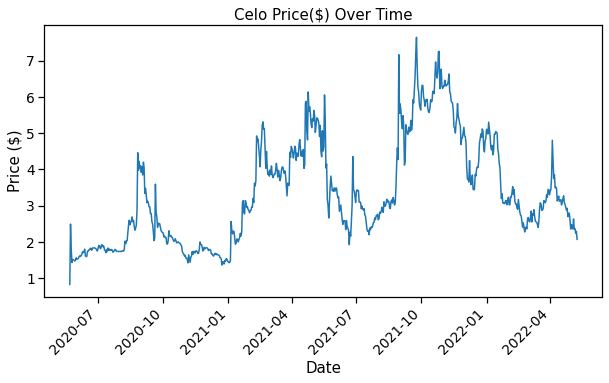

In [89]:
# line plot of crypto price over time
sns.set_context('notebook', font_scale = 1.25)
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.lineplot(x = df['Date'], y = df['Close'])
ax.set(title = 'Celo Price($) Over Time', ylabel = 'Price ($)')
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
plt.show()

As seen in the visualization above, we can see that Celo Closing Price (applies to all crypto price) is very volatile and could be any price on a given time.

## Visualize as Crypto Trading via Plotly

* Code for this visualization is taken from this [resource](https://pythoninoffice.com/draw-stock-chart-with-python/).

In [90]:
# adding a column indicator 
df['diff'] = df['Close'] - df['Open']
df.loc[df['diff'] >= 0, 'color'] = 'green'
df.loc[df['diff'] < 0, 'color'] = 'red'

In [91]:
# plot trading view via plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(go.Scatter(x=df['Date'], y = df['Close'], name = 'Price'), secondary_y = False)
fig.add_trace(go.Candlestick(x = df['Date'], 
                             open = df['Open'], 
                             high = df['High'], 
                             low = df['Low'],
                             close = df['Close'],
                             name = 'Price'
                             ))
fig.add_trace(go.Scatter(x = df['Date'], 
                         y = df['Close'].rolling(window=20).mean(), 
                         marker_color = 'blue', 
                         name = '20 Day MA'
                        ))
fig.add_trace(go.Bar(x=df['Date'], 
                     y = df['Volume'], 
                     name = 'Volume',
                     marker = {'color' : df['color']}
                     ), 
              secondary_y = True
              )
fig.update_yaxes(range = [0, 7000000000], secondary_y = True)
fig.update_yaxes(visible=False, secondary_y = True)
fig.update_layout(title = {'text': 'Celo Trading View', 'x' : 0.5})
# uncomment the line below to disable the range slider
fig.update_layout(xaxis_rangeslider_visible = False)
# fig.show('png') -> will be used to show a static view of the graph in GitHub, 
# fig.show() without any attribute will be used to make interactive in Google Colab.
fig.show()

*The visual above is a trading view of the Celo Price (Low, High and Close) daily, and the Volume by day (with green and red indicators). This also includes a 20 Day Moving Average (blue) one indicator that help traders decide whether to buy or sell or hold their assets.*

In [92]:
# save the graph above to html 
# fig.write_html(r'/content/drive/MyDrive/CodingDojo_DS/dataset_files/graph.html')

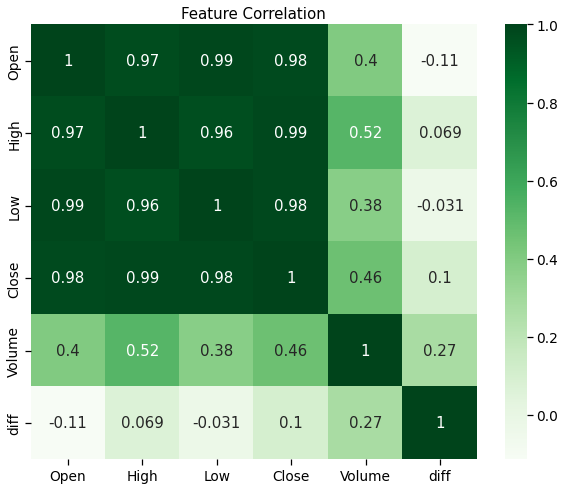

In [93]:
# heatmap plot of dimension correlation
corr = df.corr()
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr, cmap = 'Greens', annot = True)
ax.set(title = 'Feature Correlation')
plt.show()

Our data shows that prices (Open, Low, High and Closing) are greatly correlated and is also somewhat correlated to our Volume. 

## Applying Feature Engineering on Datetime

We will be adding the following dimensions from the datetime feature
- year
- month (name)
- day of month
- day of week (name)

In [94]:
# feature engineering for datetime dimension
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
# df['day of week (name)'] = df['Date'].dt.day_name()
no_date = df.drop(columns = 'Date')
no_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    718 non-null    float64
 1   High    718 non-null    float64
 2   Low     718 non-null    float64
 3   Close   718 non-null    float64
 4   Volume  718 non-null    int64  
 5   diff    718 non-null    float64
 6   color   718 non-null    object 
 7   year    718 non-null    int64  
 8   month   718 non-null    int64  
 9   day     718 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 56.2+ KB


## Machine Learning Model

Predict Close (Price) based on features. We will be testing our data with multiple Machine Learning Algorithms (Regression) and decide which Algorithm we will be using for production.

In [95]:
# set target and features
X = no_date.drop(columns = 'Close')
y = no_date['Close']
# model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [96]:
# scaler and ohe instance
scaler = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown = 'ignore')
# make selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')
# make preproce pipeline
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)
preproc = make_column_transformer(cat_tuple, num_tuple)

**Testing with XGBRegressor Model**

Testing Data Metrics
r2_score: 0.9985065094956993
mae_score: 0.021566981077194205
mse_score: 0.003191059169321322
rmse_score: 0.05648946069242759




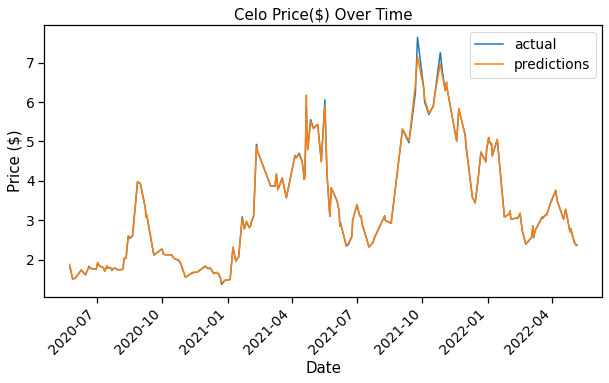

In [122]:
model = XGBRegressor(objective = 'reg:squarederror', random_state = 42)
build_n_eval_model(preproc, model, X_train, X_test, y_train, y_test)

**Testing using RandomForestRegressor**

Testing Data Metrics
r2_score: 0.9987409168708271
mae_score: 0.016331295808156312
mse_score: 0.0026902137996291345
rmse_score: 0.05186727098690594




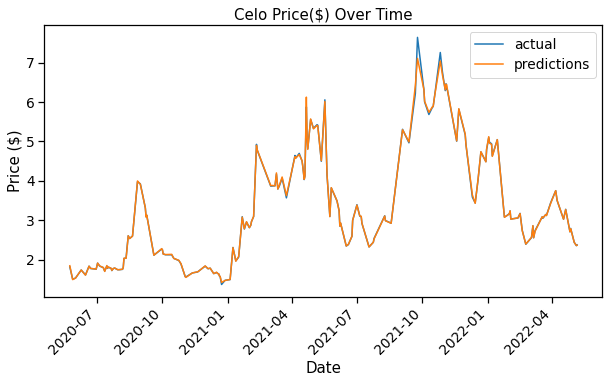

In [126]:
param_grid = {
    'max_depth' : [2, 30, 1],
    'n_estimators' : [50, 200, 25],
    'random_state' : [42]
}
rf = RandomForestRegressor()
clf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
build_n_eval_model(preproc, clf, X_train, X_test, y_train, y_test)

**LSTM Nerual Network Model**

In [128]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [135]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer='adam')


In [140]:
# model_pipe = make_pipeline(preproc, model)
preproc.fit(X_train)
train_x = preproc.transform(X_train)
test_x = preproc.transform(X_test)
model.fit(train_x, y_train, epochs = 20, batch_size = 32, verbose = 1, shuffle = True)


Epoch 1/20


ValueError: ignored